In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
apo_only= read.table('/home/hsher/scratch/circ_nextera_iter13/output/edits/APOBEC1only.dp4.neg.circ_level.tsv',
                     row.names = 1, header = TRUE, sep = ',')


In [3]:
rbp = read.table('/home/hsher/scratch/circ_nextera_iter13/output/edits/YTHDF2_STAMP.dp4.neg.circ_level.tsv',
                     row.names = 1, header = TRUE, sep = ',')

In [4]:
counts = merge(apo_only, rbp, by = 'row.names', suffixes = c(".apo",".rbp"))

In [5]:
head(counts)

,Row.names,ALT.apo,REF.apo,ALT.rbp,REF.rbp
,<I<chr>>,<int>,<int>,<int>,<int>
1,chr1:100007034|100017815,0,2720,0,1067
2,chr1:100011365|100017815,0,2622,0,371
3,chr1:100043073|100061949,0,3368,2,7087
4,chr1:100049909|100061949,0,2217,1,2931
5,chr1:100049909|100069685,0,8560,2,16533
6,chr1:100049909|100078548,1,6219,1,14139


In [6]:
counts$p_apo = (counts$ALT.apo)/(counts$ALT.apo+counts$REF.apo)

In [7]:
rbp_only = VGAM::vglm(cbind(counts$ALT.rbp, counts$REF.rbp) ~ 1, 
                           VGAM::betabinomial, trace = TRUE)

VGLM    linear loop  1 :  loglikelihood = -114077.272
VGLM    linear loop  2 :  loglikelihood = -113361.163
VGLM    linear loop  3 :  loglikelihood = -113359.38
VGLM    linear loop  4 :  loglikelihood = -113359.376
VGLM    linear loop  5 :  loglikelihood = -113359.376


In [8]:
rbp_only %>% (VGAM::coef)

(Intercept):1 (Intercept):2 
    -6.187827     -4.664262

In [ ]:
with_apo = VGAM::vglm(cbind(counts$ALT.rbp, counts$REF.rbp) ~ counts$p_apo, 
                           VGAM::betabinomial, trace = TRUE)

VGLM    linear loop  1 :  loglikelihood = -146061.648
VGLM    linear loop  2 :  loglikelihood = -135986.246
VGLM    linear loop  3 :  loglikelihood = -137285.038
Taking a modified step.
VGLM    linear loop  3 :  loglikelihood = -123528.568
VGLM    linear loop  4 :  loglikelihood = -118414.53
VGLM    linear loop  5 :  loglikelihood = -114190.647
VGLM    linear loop  6 :  loglikelihood = -110827.854
VGLM    linear loop  7 :  loglikelihood = -109481.128
VGLM    linear loop  8 :  loglikelihood = -109266.488
VGLM    linear loop  9 :  loglikelihood = -109240.445
VGLM    linear loop  10 :  loglikelihood = -109235.835


In [ ]:
with_apo %>% (VGAM::coef)

In [ ]:
VGAM::summary(with_apo)

In [24]:
VGAM::lrtest(with_apo, rbp_only)

Likelihood ratio test

Model 1: cbind(counts$ALT.rbp, counts$REF.rbp) ~ counts$p_apo
Model 2: cbind(counts$ALT.rbp, counts$REF.rbp) ~ 1
    #Df  LogLik Df  Chisq Pr(>Chisq)    
1 89201 -109235                         
2 89202 -113359  1 8249.4  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
hist(VGAM::fitted(with_apo))

In [16]:
max(VGAM::fitted(with_apo))

[1] 0.8985927

In [17]:
model = with_apo
model_coef = model %>% (VGAM::coef) %>% as_tibble(rownames="coef")%>% transmute(coef = c("mu","rho","counts$p_apo"),value)
model_overdispersion = model_coef$value[2]
counts$fitted=c(VGAM::fitted(model))
result = counts %>%mutate(
    pvalue = pmax(1e-13, 1 - VGAM::pbetabinom(q = ALT.rbp, size = ALT.rbp + REF.rbp, 
                                              prob = fitted, 
                                            rho = model_overdispersion %>% (VGAM::logitlink)(inverse=TRUE) ))
    )

In [18]:
write_tsv(result, 'testing_result_with_APO.tsv')

Warning message in plot.window(xlim, ylim, "", ...):
“"alpha" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"alpha" is not a graphical parameter”
Warning message in axis(1, ...):
“"alpha" is not a graphical parameter”
Warning message in axis(2, at = yt, ...):
“"alpha" is not a graphical parameter”


ERROR: Error in seq.default(0.05, 1, length(y)): object 'y' not found


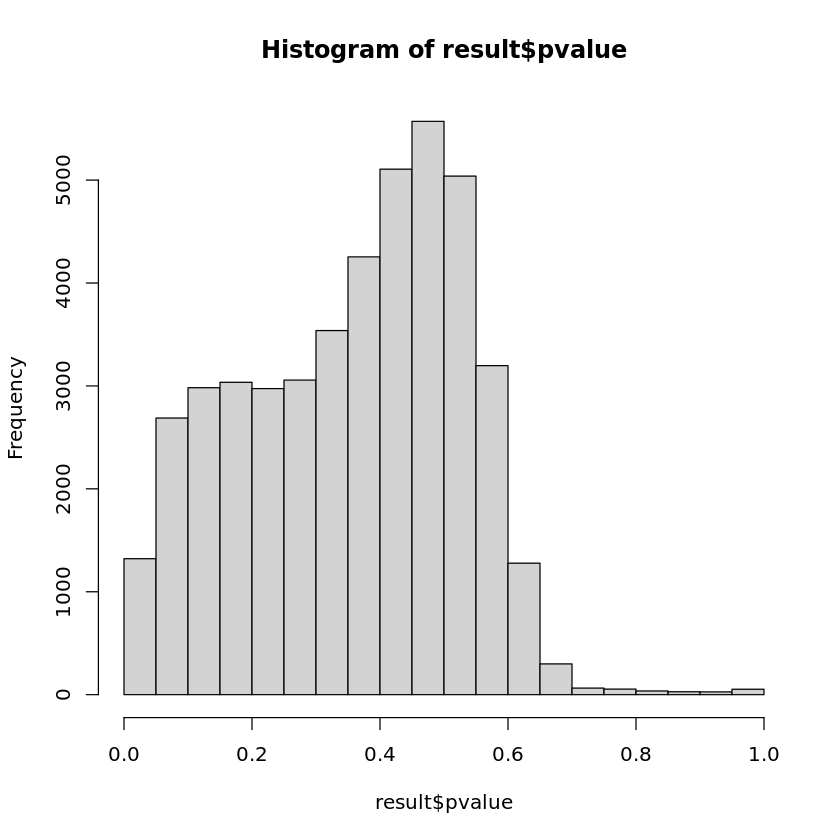

In [19]:
hist(result$pvalue, alpha = 0.1)

seq(0.05,1,length(y))
plot(1:n/(n+1),sort(y))

In [20]:
model = rbp_only
model_coef = model %>% (VGAM::coef) %>% as_tibble(rownames="coef")%>% transmute(coef = c("mu","rho"),value)
model_overdispersion = model_coef$value[2]
counts$fitted=c(VGAM::fitted(model))
result = counts %>%mutate(
    pvalue = pmax(1e-13, 1 - VGAM::pbetabinom(q = ALT.rbp, size = ALT.rbp + REF.rbp, 
                                              prob = fitted, 
                                            rho = model_overdispersion %>% (VGAM::logitlink)(inverse=TRUE) ))
    )

In [21]:
max(result$fitted)

[1] 0.002050074

In [22]:
write_tsv(result, 'testing_result_RBPonly.tsv')

Warning message in plot.window(xlim, ylim, "", ...):
“"alpha" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"alpha" is not a graphical parameter”
Warning message in axis(1, ...):
“"alpha" is not a graphical parameter”
Warning message in axis(2, at = yt, ...):
“"alpha" is not a graphical parameter”


[1] 0.05

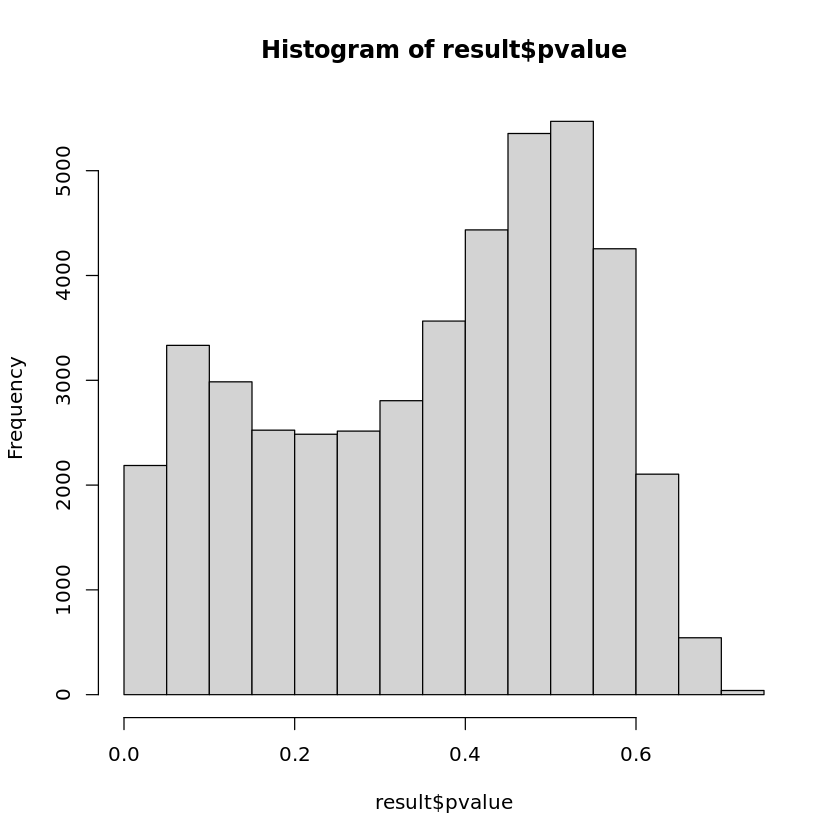

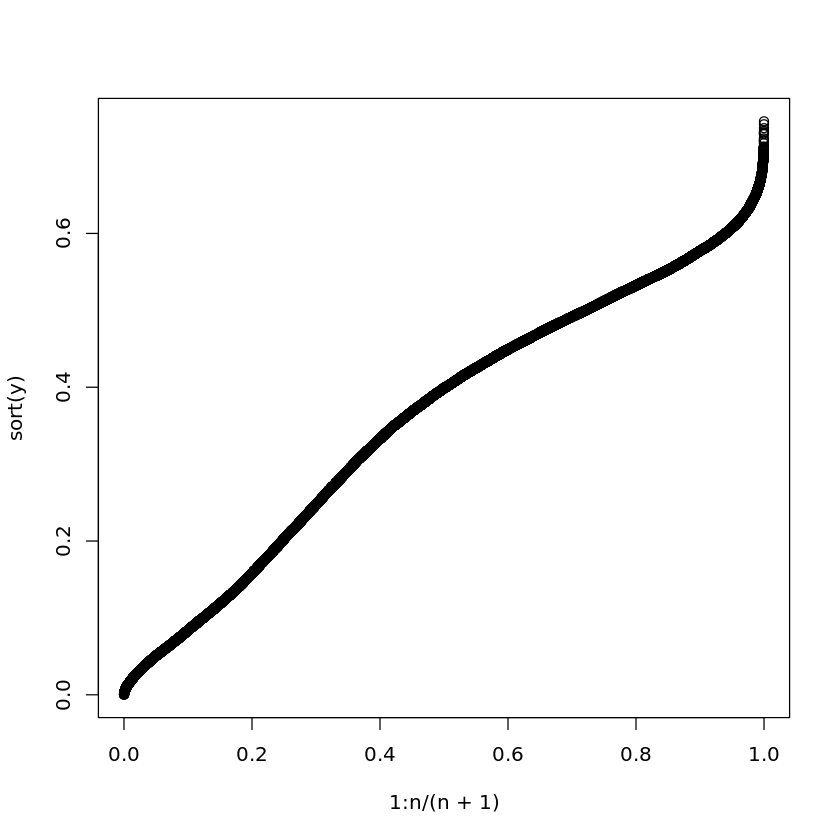

In [23]:
hist(result$pvalue, alpha = 0.1)

n =length(result$pvalue)
y = result$pvalue

seq(0.05,1,length(y))
plot(1:n/(n+1),sort(y))


In [ ]:

write_tsv(result2, 'testing_result2.tsv')

In [ ]:
length(result$pvalue)

In [ ]:
n =length(result$pvalue)
y = result$pvalue

seq(0.05,1,length(y))
plot(1:n/(n+1),sort(y))
